# [4등] 신용카드 거래 데이터 시각화

https://dacon.io/competitions/official/42473/codeshare/437?page=2&dtype=recent </br>
(5등 코드와 동일)

In [3]:
# 패키지 설치
install.packages("dplyr")
install.packages("data.table")
install.packages("ggplot2")
install.packages("MASS")
install.packages("lattice")
install.packages("corrplot")
install.packages("corrgram")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘gridExtra’, ‘bitops’, ‘foreach’, ‘viridis’, ‘gtools’, ‘caTools’, ‘TSP’, ‘qap’, ‘gclus’, ‘dendextend’, ‘gplots’, ‘registry’, ‘seriation’




In [4]:
# 패키지 불러오기
library(dplyr)
library(data.table)
library(ggplot2)
library(MASS)
library(lattice)
library(corrplot)
library(corrgram)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


corrplot 0.84 loaded


Attaching package: ‘corrgram’


The following object is masked from ‘package:lattice’:

    panel.fill




### 데이터 불러오기

>코랩에서 R을 쓸 때는 드라이브 마운트가 안 돼서 파일 고유 ID를 얻은 후 다운받아 불러와야 한다! (https://stackoverflow.com/questions/59746036/how-to-read-data-from-google-drive-using-r-in-colab)

In [89]:
# 파일 읽어오기
system("gdown --id 11VEsPIimNLpkbfaWi8WEK8779TeSk2_9")
train <- read.csv("train.csv", encoding = "UTF-8")

In [90]:
head(train)

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,0,2016-12-14,18:05:31,d297bba73f,5,NA,2,0
2,0,2016-12-14,18:05:54,d297bba73f,-5,NA,2,0
3,0,2016-12-19,12:42:31,0880849c05,144,NA,0,0
4,0,2016-12-19,12:48:08,8b4f9e0e95,66,NA,0,0
5,0,2016-12-19,13:31:08,7ad237eed0,24,NA,0,0
6,0,2016-12-19,13:36:39,30b1422f77,44,NA,0,0


In [91]:
#amount가 0원인 데이터는 제거 
train <- train[train$amount != 0,] 

### 변수 만들기

> **gsub()**: 특정 문자열을 찾아서 다른 문자열로 바꿔주는 함수 </br>
(찾을 것, 바꿀 것, 열 지정)

In [93]:
#요일변수 만들기
train$weekday <- train$days_of_week
train$weekday <- gsub("0","Mon",train$weekday)
train$weekday <- gsub("1","Tue",train$weekday)
train$weekday <- gsub("2","Wed",train$weekday)
train$weekday <- gsub("3","Thu",train$weekday)
train$weekday <- gsub("4","Fri",train$weekday)
train$weekday <- gsub("5","Sat",train$weekday)
train$weekday <- gsub("6","Sun",train$weekday)

> **substr()**: 시작점과 끝점을 지정해주어 문자열을 split할 수 있음!

In [94]:
# 시간변수 만들기
train$hour <- substr(train$time, 1,2) 

In [95]:
# 연도 변수 만들기
train$year <- substr(train$date,1,4)

In [96]:
# 월 변수 만들기
train$month <- substr(train$date,6,7)
train$season <- train$month
train$season <- gsub("12","Winter",train$season)
train$season <- gsub("01","Winter",train$season)
train$season <- gsub("02","Winter",train$season)
train$season <- gsub("03","Spring",train$season)
train$season <- gsub("04","Spring",train$season)
train$season <- gsub("05","Spring",train$season)
train$season <- gsub("06","Summer",train$season)
train$season <- gsub("07","Summer",train$season)
train$season <- gsub("08","Summer",train$season)
train$season <- gsub("09","Fall",train$season)
train$season <- gsub("10","Fall",train$season)
train$season <- gsub("11","Fall",train$season)

### amount 계산

In [98]:
# 할부 여부 확인
train2 <- train
t <- table(!is.na(train2$installments))
t/sum(t)


      FALSE        TRUE 
0.994984788 0.005015212 

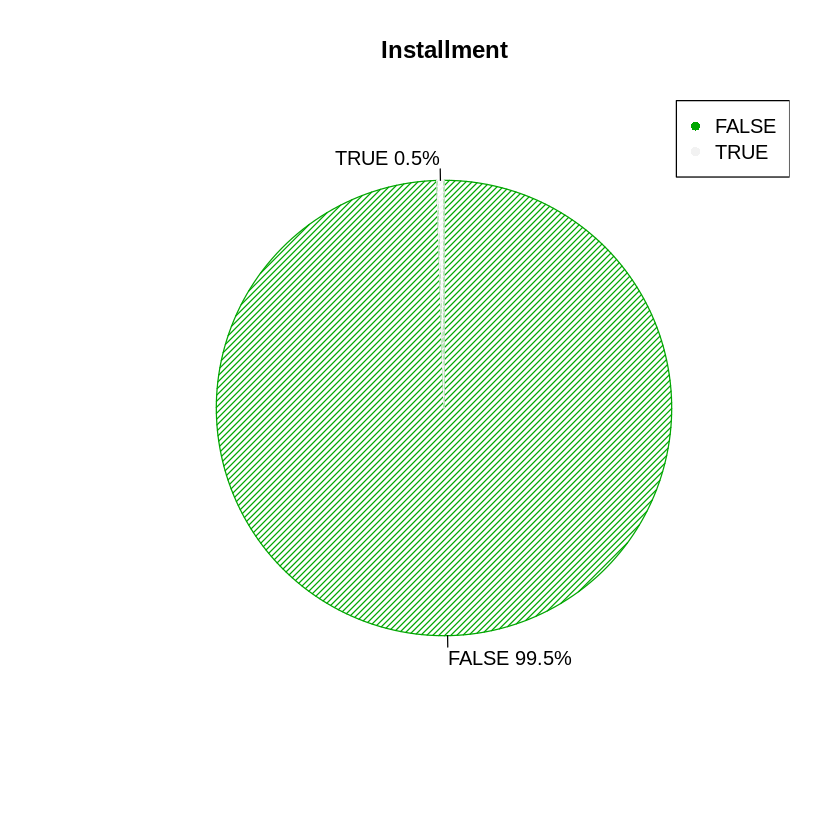

In [99]:
# 구매비율 파이차트 
?terrain.colors
season2 <- terrain.colors(2, alpha = 1)#(2, s = 1, v = 1, start = 0, end = max(1,4 - 1)/8, alpha = 0.7) # 색 정하기
name = paste(names(t/sum(t)), " ",
             round(t/sum(t)/sum(t/sum(t)),3)*100,"%",sep = "") # 파이 차트에 표시되는 퍼센트 만들어주기 
pie(t/sum(t),label = name,density = 30,col = season2, clockwise = T) # 파이 차트 그리기
legend( "topright", legend = c('FALSE','TRUE'),
        pch=16, col=season2,xjust=1,yjust=1) # 범례

sum_t <- t/sum(t)


installments가 결측값인 경우 즉, 일시불로 계산한 경우가 대부분인 것을 알 수 있음!

### 카드별 총 매출 구하기

In [101]:
# 카드별 매출 그룹화 
train3 <- train %>% group_by(card_id) %>% summarise(sum_am = sum(amount))
train3 %>% head

train4 <- train3

card_id,sum_am
<chr>,<int>
000009e765,10
00000f9eaa,331
0000134335,90
000024f480,80
000036a26b,720
00003c84e3,255


In [102]:
# 카드별 매출 분포 확인
max(train3$sum_am) 
min(train3$sum_am)

[1] 761667

[1] -10904

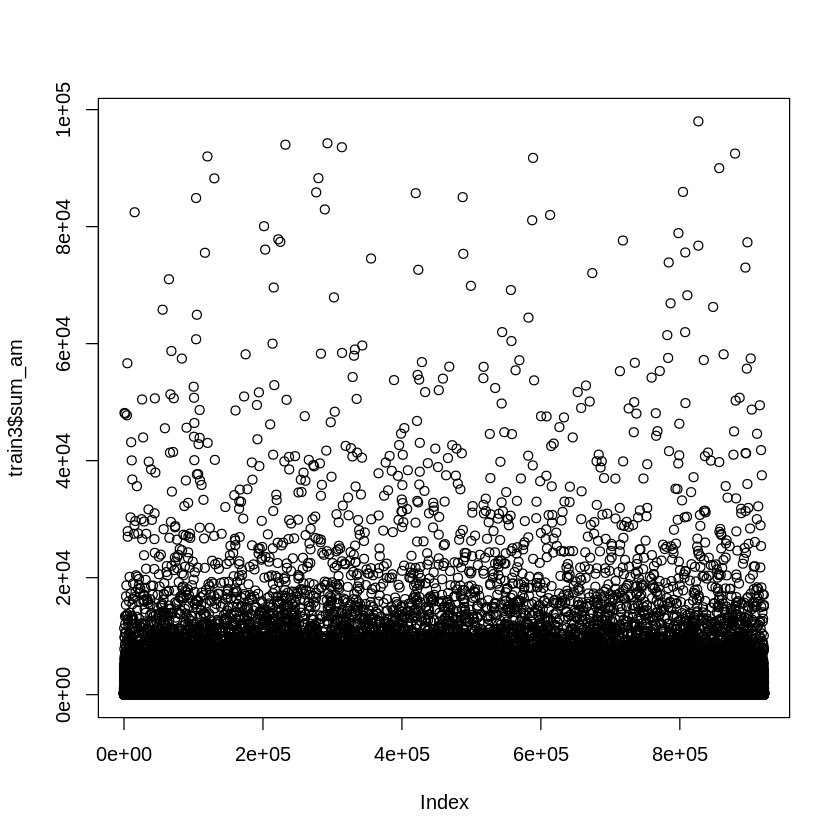

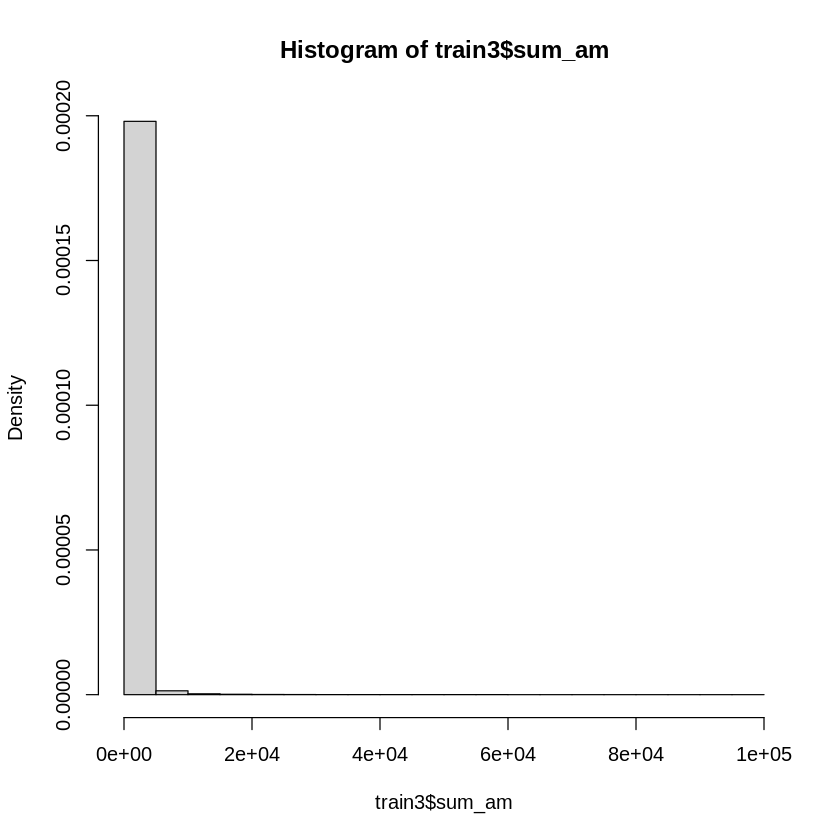

In [103]:
train3 <- train3[train3$sum_am > 0,] # 음수인 경우 제외
train3 <- train3[train3$sum_am < 100000,] # 100000 이상인 경우 제외
plot(train3$sum_am)
x <- hist(train3$sum_am, freq = F)

In [104]:
x1 <- data.frame(x$counts)
x2 <- data.frame(x$breaks)
x3 <- x2$x.breaks[-21]
x3 <- cbind(x1, x3) # 구간별 카드 매출확인을 위해 만듦.

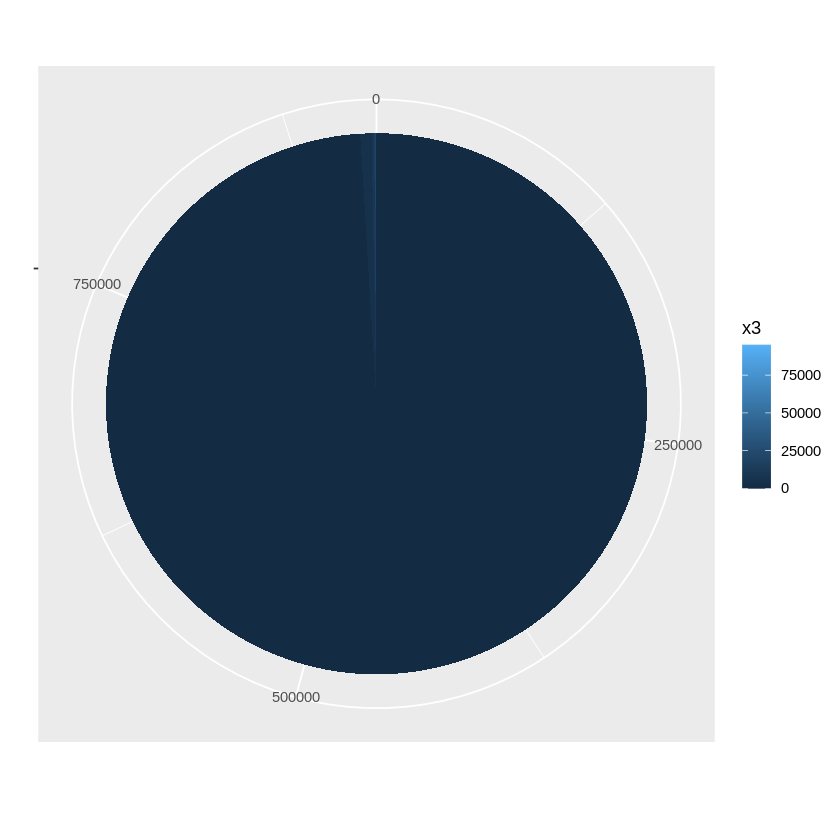

In [105]:
# 카드별 매출합 비율
ggplot(data=x3, aes(x="", y=x.counts, fill= x3)) + 
  geom_bar(stat="identity", width=5)+
  coord_polar(theta="y") + # 단위는 5000마다 기준으로 나s뉨
  xlab("")+
  ylab("")+
  theme(plot.title=element_text(family="NanumGothicCoding", 
                                face="bold", size=30, vjust=1,hjust = 0.5, color="gray"))

육안으로는 구별하기 힘든 결과가 나옴
 **-> 로그변환 해보자!**

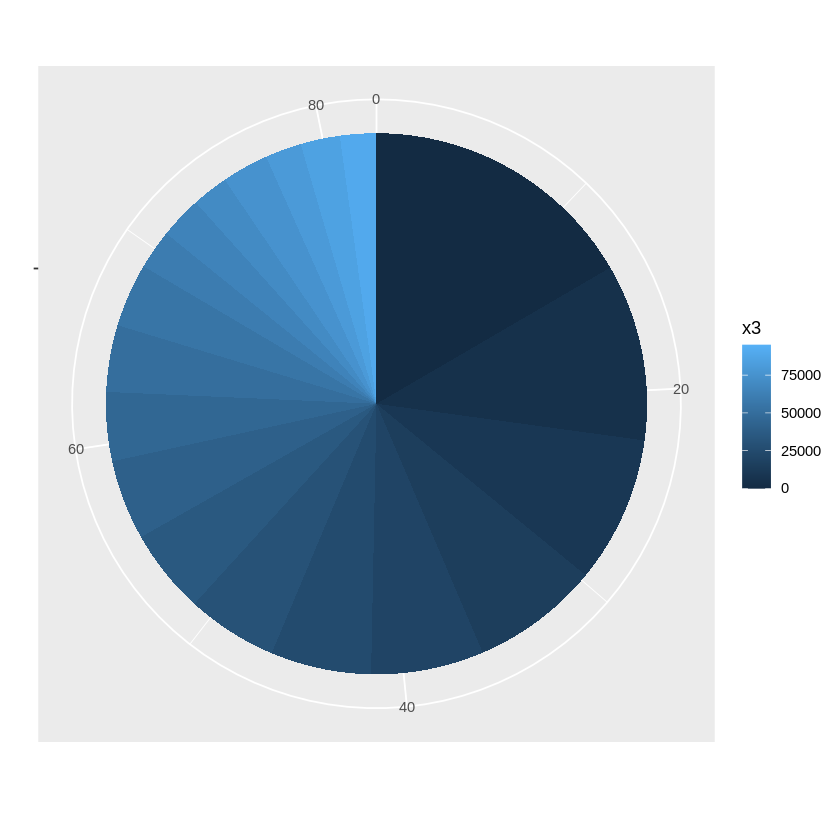

In [106]:
# 카드별 매출합 비율(로그변환O)
ggplot(data=x3, aes(x="", y=log(x.counts), fill= x3)) + # 5000이하의 비중이 너무 커서 로그값으로 넣어줌
  geom_bar(stat="identity", width=5)+
  coord_polar(theta="y") +
  xlab("")+
  ylab("")+
  theme(plot.title=element_text(family="NanumGothicCoding", 
                                face="bold", size=30, vjust=1,hjust = 0.5, color="gray"))

로그를 써서 구분한 결과, 작은 금액 단위로 계산한 비율이 높은 것을 알 수 있음!

**결론 : 카드 매출은 소액결제가 많음! 그 외에는 카드매출로 특별한 점을 찾기 어려움**

### 지점별 총 매출

In [139]:
train5 <- train %>% group_by(store_id) %>% summarise(sum_am = sum(amount))
train5 %>% head

store_id,sum_am
<int>,<int>
0,5234611
1,147950
2,1615060
3,62781
4,270312
5,184437


In [140]:
train6 <- train5
max(train5$sum_am)
min(train5$sum_am)


train5 <- train5[train5$sum_am > 0,]
train5 <- train5[train5$sum_am < 100000,]

[1] 9474601

[1] 0

In [141]:
# 상점별 매출이 0인 곳은 제외
#train5 <- train5[train5$sum_am >100,]
#train5 <- train5[train5$sum_am < x$breaks[2],] # 매출액이 너무 큰것은 이상치로 보고 제외

$breaks
 [1] 0e+00 1e+04 2e+04 3e+04 4e+04 5e+04 6e+04 7e+04 8e+04 9e+04 1e+05

$counts
 [1] 162 125  99  82  74  61  54  56  53  37

$density
 [1] 2.017435e-05 1.556663e-05 1.232877e-05 1.021171e-05 9.215442e-06
 [6] 7.596513e-06 6.724782e-06 6.973848e-06 6.600249e-06 4.607721e-06

$mids
 [1]  5000 15000 25000 35000 45000 55000 65000 75000 85000 95000

$xname
[1] "train5$sum_am"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

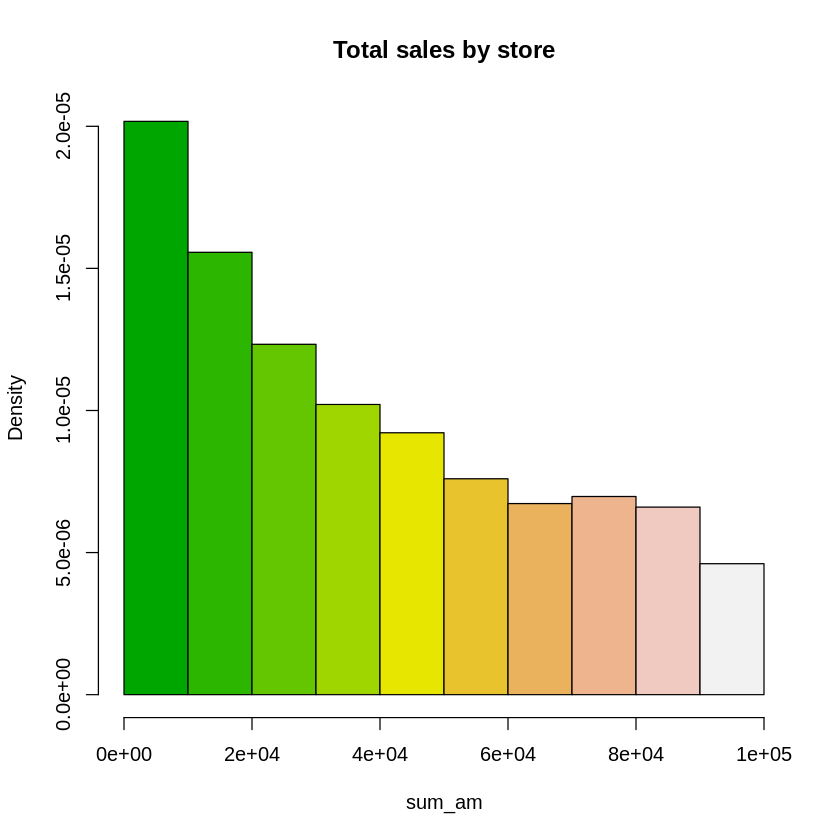

In [142]:
season1 <- terrain.colors(10, alpha = 1) # 색 지정

hist1 <- hist(train5$sum_am, freq = F, main = "Total sales by store", xlab = "sum_am", col =season1) 
hist1

금액이 낮은 순으로 결제한 비율이 높음!

`summarise()` has grouped output by 'hour', 'month', 'year', 'days_of_week'. You can override using the `.groups` argument.



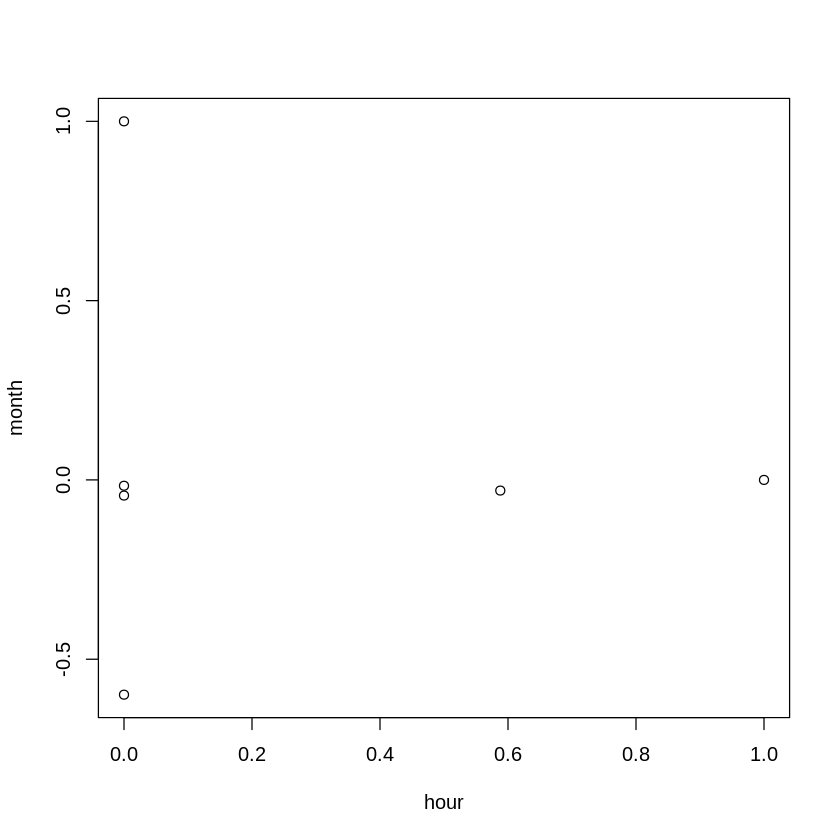

In [144]:
## 상관관계 
train2 <- train
train2$hour <- as.numeric(train2$hour)
train2$month <- as.numeric(train2$month)
train2$year <- as.numeric(train2$year)

train10 <- train2 %>% group_by(hour, month, year,  days_of_week, holyday) %>% summarise(sum_am = sum(amount))
plot(cor(train10))

In [145]:
# 의미있는 변수끼리 추출

cor(train10[,c(1,6)])[2]

cor(train10[,c(2,3)])[2]


[1] 0.587956

[1] -0.5988705

시간과 매출합: 0.59, 월과 연도: -6.0

### 매출 그래프

`summarise()` has grouped output by 'hour', 'month', 'year'. You can override using the `.groups` argument.



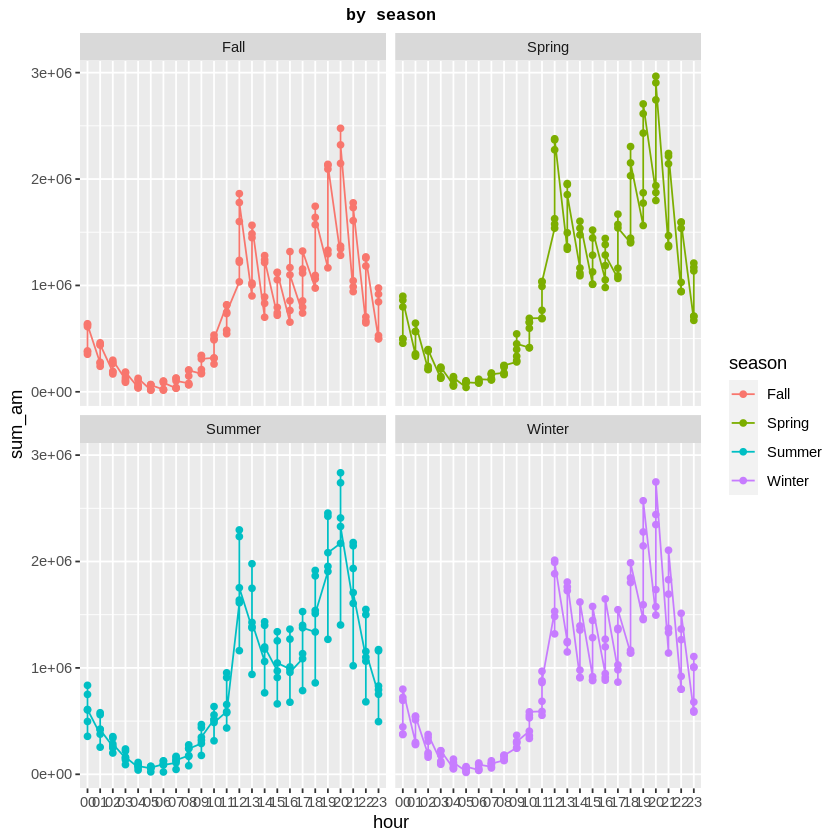

In [146]:
# 계절별 매출그래프

train9 <- train %>% group_by(hour, month, year, season) %>% summarise(sum_am = sum(amount))

ggplot(data = train9, aes(x = train9$hour, y = train9$sum_am, group = season, colour = season))+
  geom_point() +
  geom_line() +
  facet_wrap(~ season) +
  xlab("hour") +
  ylab("sum_am") +
  ggtitle("by season") +
  theme(plot.title=element_text(family="NanumGothicCoding", 
                                face="bold", size=10, vjust=1,hjust = 0.5, color="black"))

봄에 매출이 가장 높고 가을에 제일 낮음


`summarise()` has grouped output by 'hour', 'month'. You can override using the `.groups` argument.



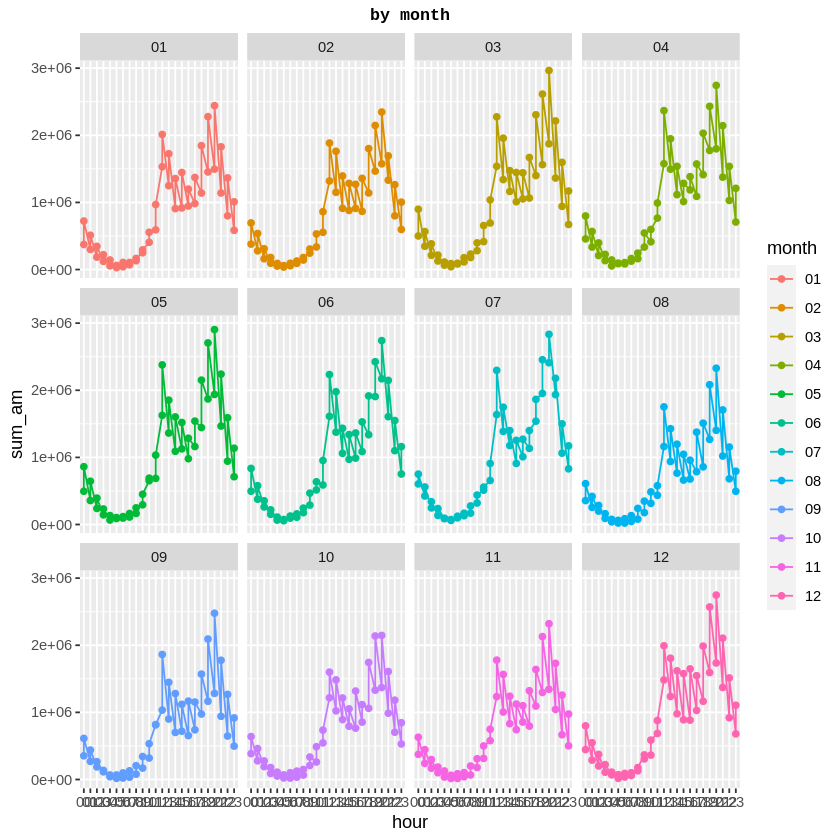

In [147]:
# 월별 매출그래프

train9 <- train %>% group_by(hour, month, year) %>% summarise(sum_am = sum(amount))

ggplot(data = train9, aes(x = train9$hour, y = train9$sum_am, group = month, colour = month))+
  geom_point() +
  geom_line() +
  facet_wrap(~ month) +
  xlab("hour") +
  ylab("sum_am") +
  ggtitle("by month") +
  theme(plot.title=element_text(family="NanumGothicCoding", 
                                face="bold", size=10, vjust=1,hjust = 0.5, color="black"))

3, 4, 5, 6, 7, 12월에 매출 높음

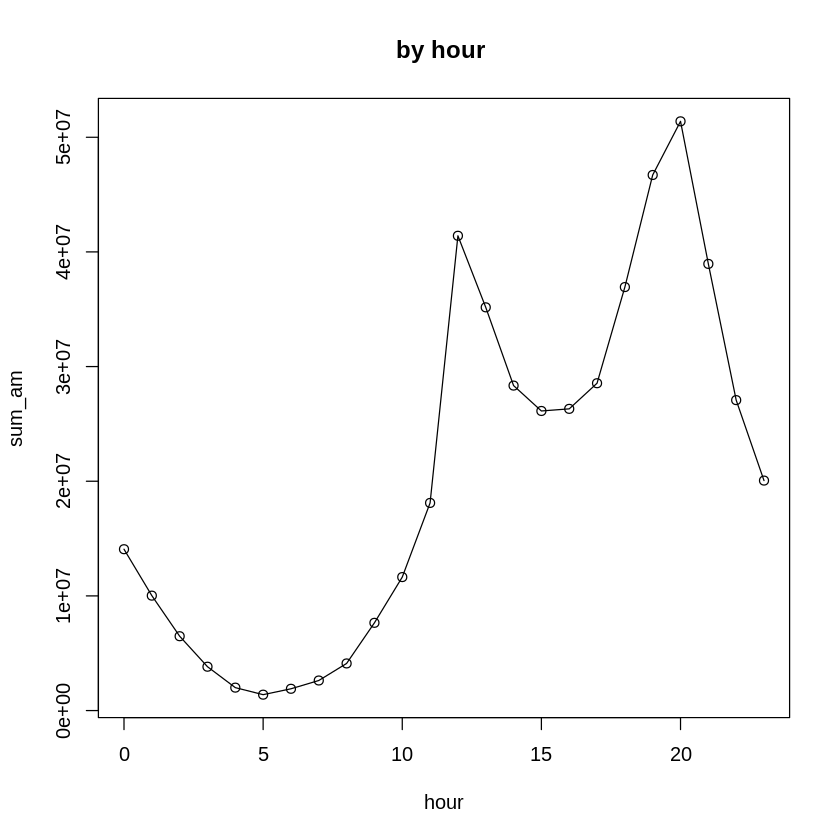

In [148]:
# 시간별 매출
train8 <- train %>% group_by(hour) %>% summarise(sum_am = sum(amount))
plot(train8$hour, train8$sum_am, main = "by hour ", xlab = "hour", ylab = "sum_am")
lines(train8$hour, train8$sum_am)

20시에 매출이 가장 높음

`summarise()` has grouped output by 'hour', 'weekday'. You can override using the `.groups` argument.



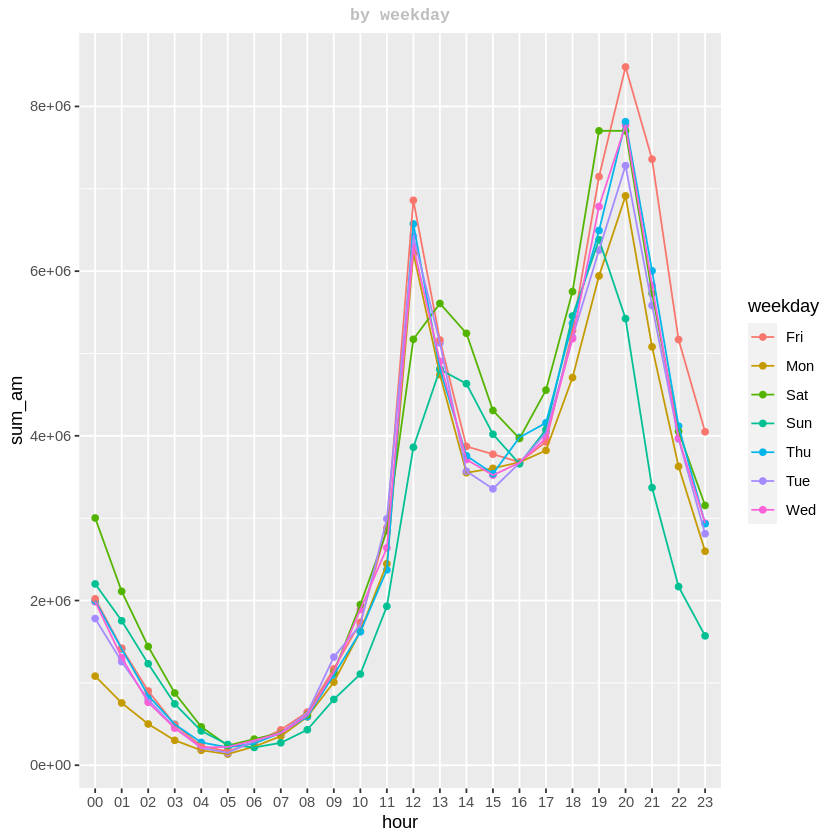

In [149]:
##요일 및 시간별 매출  
train9 <- train %>% group_by(hour, weekday, days_of_week) %>% summarise(sum_am = sum(amount))
train9 <- train9[c(order(train9$days_of_week)),] # 정렬

ggplot(data = train9, aes(x = train9$hour, y = train9$sum_am, group = weekday, colour = weekday))+
  geom_point() +
  geom_line() +
  ggtitle("by weekday") +
  xlab("hour")+
  ylab("sum_am")+
  theme(plot.title=element_text(family="NanumGothicCoding", 
                                face="bold", size=10, vjust=1,hjust = 0.5, color="gray")) 

- 12시-13시, 19시-21시가 매출이 높은 시간대
- 토요일, 일요일의 경우 평일과 다른 추이


`geom_smooth()` using formula 'y ~ x'



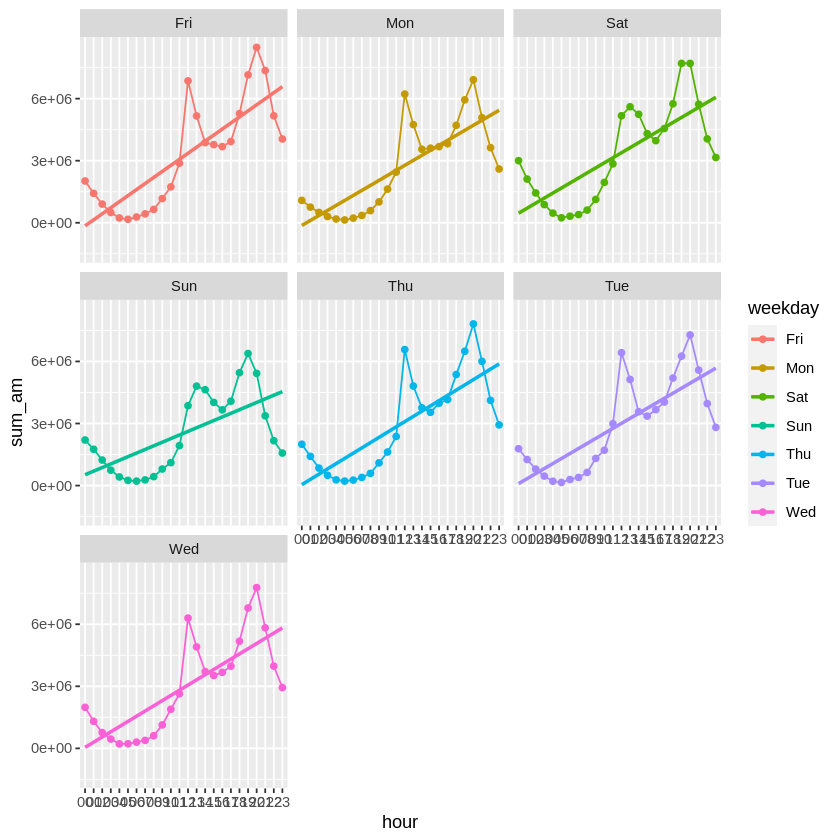

In [126]:
# 요일별로 그래프 따로 보기
ggplot(data = train9, aes(x = train9$hour, y = train9$sum_am, group = weekday, colour = weekday))+
  geom_point() +
  geom_line() +
  geom_smooth(method="lm",fill=NA,fullrange=TRUE) +
  facet_wrap(~ weekday) +
  xlab('hour')+
  ylab("sum_am")+
  theme(plot.title=element_text(family="NanumGothicCoding", 
                                face="bold", size=10, vjust=1,hjust = 0.5, color="gray")) 

금요일 저녁 매출이 제일 높음, 월요일과 일요일에 낮음

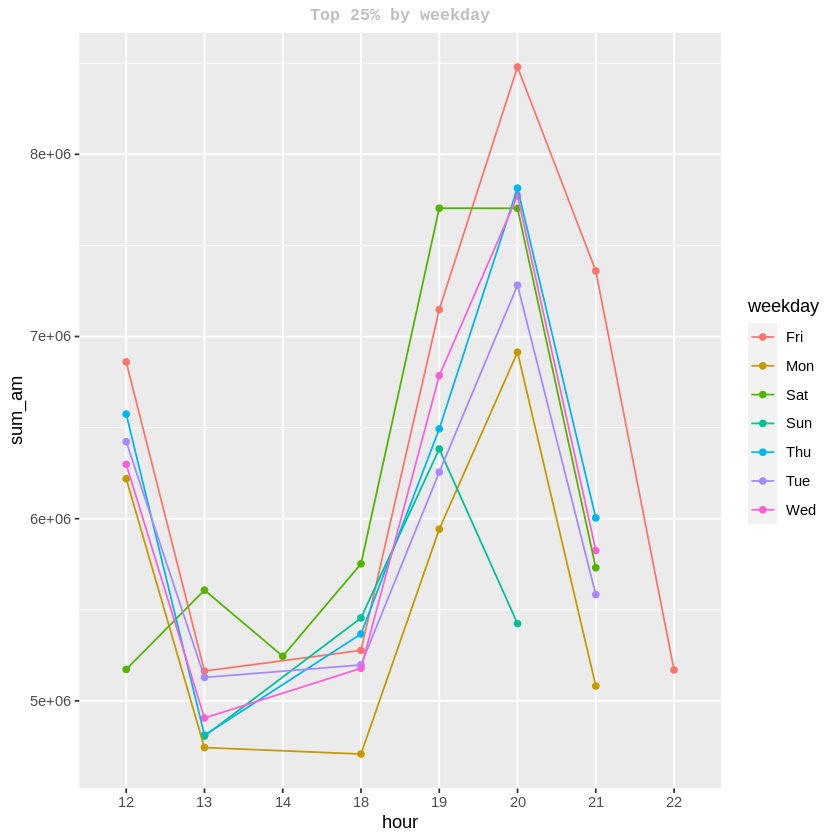

In [127]:
# 요일별 상위 25% 매출 
sum_03 <-  sum(train9$sum_am)/length(train9$sum_am)  
train10 <- train9[train9$sum_am > summary(train9$sum_am)[5],]

ggplot(data = train10, aes(x = train10$hour, y = train10$sum_am,group = weekday, colour = weekday))+
  geom_point() +
  geom_line() +
  ggtitle("Top 25% by weekday") +
  xlab("hour")+
  ylab("sum_am")+
  theme(plot.title=element_text(family="NanumGothicCoding", 
                                face="bold", size=10, vjust=1,hjust = 0.5, color="gray")) 

- 마찬가지로 12시, 19-20시에 매출이 높음
- 금요일 매출이 제일 높고 일요일 매출이 유독 낮음

### 최종 결론

1. 소액결제가 많음
2. 매출은 봄(3,4,5월)에 가장 높음
3. 매출이 가장 높은 시간대는 19-20시 사이
4. 금요일 저녁에 매출이 가장 높음
5. 월요일과 일요일의 매출은 다른 날에 비해 적음